# Assignment 02: CLIP

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torchvision

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from clip import clip

### Hyperparameters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 5
EVAL_INTERVAL=1
# SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'ViT-B/32' # RN50, ViT-B/32, ViT-B/16,ViT-L/14,RN101,RN50x4,RN50x16,RN50x64,ViT-L/14@336px


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


##### CIFAR10

In [4]:
# # cifar10 transform
# transform_cifar10_test = transforms.Compose([
#     transforms.Resize(size=224),
#     transforms.CenterCrop(size=(224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# test_set = torchvision.datasets.CIFAR10(root='/data/dataset/', train=False,
#                                        download=True, transform=transform_cifar10_test)
# test_dataloader_CIFAR10 = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
#                                          shuffle=False, num_workers=2)

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# dataset_name = 'CIFAR10'

Files already downloaded and verified


##### MNIST

In [4]:
# MNIST transform
transform_mnist = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = torchvision.datasets.MNIST(root='../data/dataset/', train=True,
                                        download=True, transform=transform_mnist)
train_dataloader_MNIST = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='../data/dataset/', train=False,
                                       download=True, transform=transform_mnist)
test_dataloader_MNIST = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


In [5]:
train_dataloader = train_dataloader_MNIST 

test_dataloader = test_dataloader_MNIST #test_dataloader_CIFAR10
# test_dataloader = test_dataloader_CIFAR10

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 
dataset_name = 'MNIST' #'CIFAR10', 'MNIST'

### Model

##### Clip

In [6]:
# Load the model clip
model_clip, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')

In [7]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

##### Resnet50

In [8]:
model_resnet50 = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc.requires_grad = True

fc_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(fc_features,10)

##### LeNet

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #原始图像32*32*3（224*224）
        self.conv1 = nn.Conv2d(3, 6, 5)
        #输出：28x28x6（220*220*6）
        self.pool = nn.MaxPool2d(2, 2)
        #输出：14x14x6（110*110*6）
        self.conv2 = nn.Conv2d(6, 16, 5)
        #输出：10x10x16（106*106*16）
        
        #池化后，输出：5x5x16（53*53*16）
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [7]:
# model = LeNet()
# model = model_resnet50
model = model_clip
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


### Model Training
---

1.LeNet

#### 1.Optimizer and Loss function

In [8]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

#### 2.per batch training/testing

In [9]:
def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output,target)
    return output, loss

#### 3.training

LeNet

In [10]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################
    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    
    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

Epoch: 1/5 Train Loss: 0.0019 Acc: 0.9248
Begin test......
Test Loss: 0.0008 Acc: 0.9687
Epoch: 2/5 Train Loss: 0.0005 Acc: 0.9821
Begin test......
Test Loss: 0.0006 Acc: 0.9762
Epoch: 3/5 Train Loss: 0.0003 Acc: 0.9893
Begin test......
Test Loss: 0.0006 Acc: 0.9771
Epoch: 4/5 Train Loss: 0.0002 Acc: 0.9931
Begin test......
Test Loss: 0.0007 Acc: 0.9758
Epoch: 5/5 Train Loss: 0.0001 Acc: 0.9951
Begin test......
Test Loss: 0.0007 Acc: 0.9792


LeNet

In [11]:
training_loss_LeNet = training_loss
training_acc_LeNet = training_acc
testing_loss_LeNet = testing_loss
testing_acc_LeNet = testing_acc

### Model Testing
---

1. CLIP
2. linear-probe CLIP
3. ResNet50

#### 1.Prompt Gereration

In [9]:
# prompt = 'a photo of a'
prompt = 'a photo of the number:'

def prompt_encode(prompt):
    
    text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)
    
    return text_inputs

In [10]:
[f"{prompt} {c}"for c in class_names]

['a photo of the number: 0',
 'a photo of the number: 1',
 'a photo of the number: 2',
 'a photo of the number: 3',
 'a photo of the number: 4',
 'a photo of the number: 5',
 'a photo of the number: 6',
 'a photo of the number: 7',
 'a photo of the number: 8',
 'a photo of the number: 9']

#### 2.Zero-shot inference

In [11]:
def model_inference(model, image, text_inputs):

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
        
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
#         similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# #         values, indices = similarity.topk(10)
#         logits = similarity

        logit_scale = model.logit_scale.exp()#100
        logits = logit_scale * image_features @ text_features.t()
        
    return logits

In [ ]:
# image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)

In [13]:
torch.cuda.empty_cache()

#### 3.testing

Zero-shot CLIP

In [12]:
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image,prompt_encode(prompt))
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on MNIST is 21.21%, visual encoder is RN101.


In [8]:
m = ['ViT-L/14','ViT-B/32','RN101','RN50']
# testing_acc_clip_mnist = []
m

['ViT-L/14', 'ViT-B/32', 'RN101', 'RN50']

In [ ]:
# testing_acc_clip_mnist.append(val_acc.cpu().detach().numpy())

In [48]:
testing_acc_clip_mnist #[np.array(0.6355), np.array(0.4302), np.array(0.2121), np.array(0.1912)]

[array(0.6355), array(0.4302), array(0.2121), array(0.1912)]

Linear-probe evaluation CLIP

In [59]:
def get_features(dataloader):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train_dataloader)
test_features, test_labels = get_features(test_dataloader)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy of linear-probe {VISUAL_BACKBONE} = {accuracy:.3f}")

100%|██████████| 79/79 [00:10<00:00,  7.85it/s]
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5130     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38155D+05    |proj g|=  6.52032D+03

At iterate   50    f=  7.82956D+03    |proj g|=  3.68380D+02

At iterate  100    f=  5.40648D+03    |proj g|=  7.97022D+01

At iterate  150    f=  5.07817D+03    |proj g|=  1.19791D+02

At iterate  200    f=  4.98902D+03    |proj g|=  1.15466D+02

At iterate  250    f=  4.96141D+03    |proj g|=  2.93356D+01

At iterate  300    f=  4.95597D+03    |proj g|=  6.65982D+00

At iterate  350    f=  4.95471D+03    |proj g|=  1.48864D+01

At iterate  400    f=  4.95431D+03    |proj g|=  1.37741D+01

At iterate  450    f=  4.95408D+03    |proj g|=  1.99107D+00

At iterate  500    f=  4.95388D+03    |proj g|=  6.61429D+00

At iterate  550    f=  4.95360D+03    |proj g|=  4.34350D+00

At iterate  600    f=  4.95255D+03    |proj g|=  4.89716D+00

At iterate  650    f=  4.9

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
# testing_acc_clip_linearprob_ViTB32 = accuracy/100
testing_acc_clip_linearprob_ViTB32 # 0.9849

In [19]:
# testing_acc_clip_linearprob_RN50 = accuracy/100
testing_acc_clip_linearprob_RN50 # 0.897

0.897

In [9]:
# testing_acc_clip_linearprob_RN101 = accuracy/100
testing_acc_clip_linearprob_RN101 # 0.8906

0.8905999999999998

In [27]:
# testing_acc_clip_mnist_linearprobe =[0,testing_acc_clip_linearprob_ViTB32,
#                                      testing_acc_clip_linearprob_RN101,testing_acc_clip_linearprob_RN50]
testing_acc_clip_mnist_linearprobe #[0, 0.9849, 0.8906, 0.897]

[0, 0.9849, 0.8906, 0.897]

ResNet50

In [11]:
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the performance on {dataset_name} is {val_acc*100:.2f}%, model is ResNet50.")

the performance on MNIST is 16.01%, model is ResNet50.


In [14]:
# testing_acc_resnet50_mnist = val_acc.cpu().detach().numpy()
testing_acc_resnet50_mnist #np.array(0.1601)

array(0.1601)

### Plot

#### 1.MNIST

In [10]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0:20,]
class20 = classes[0:20,]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

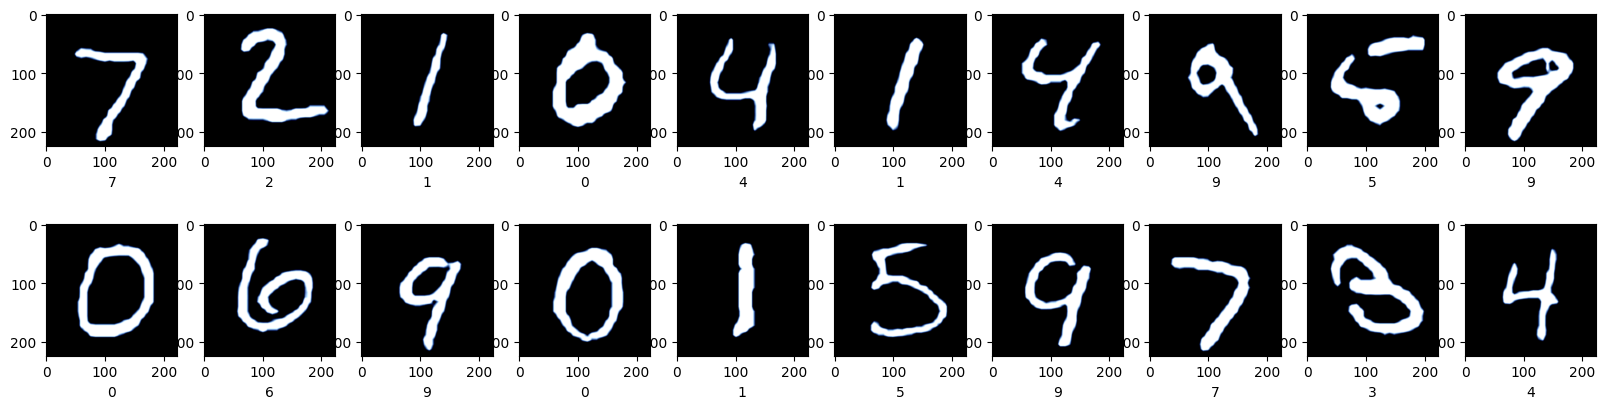

In [12]:
plt.figure(figsize=(20, 5))
for i in range(len(input)):
    image = input[i].numpy().transpose((1, 2, 0))
    plt.subplot(2, 10, i+1)
    plt.imshow(image)
#     plt.axis('off')
    plt.xlabel(class20[i].item())
plt.savefig('mnist.png')
plt.show()

#### 2.LeNet 

In [15]:
# training_acc_LeNet = [np.array(0.9223),np.array(0.9806),np.array(0.9896),np.array(0.9926),np.array(0.9951)]
# testing_acc_LeNet = [np.array(0.9733),np.array(0.9800),np.array(0.9773),np.array(0.9781),np.array(0.9787)]

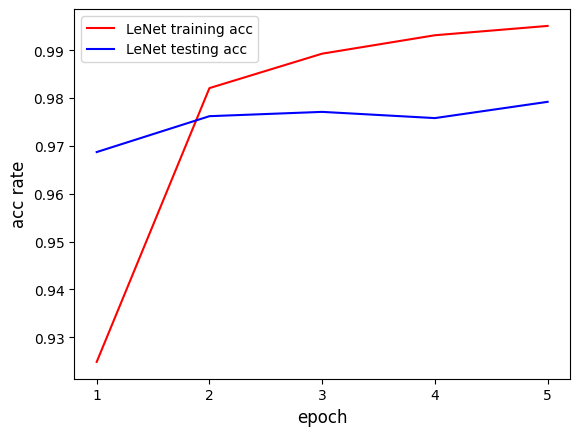

In [13]:
plt.figure()
plt.plot(list(range(1,6)),training_acc_LeNet,color='r',label='LeNet training acc')
plt.plot(list(range(1,6)),testing_acc_LeNet,color='b',label='LeNet testing acc')

plt.xticks(np.arange(1, 6, 1))

plt.xlabel("epoch",size=12)
plt.ylabel("acc rate",size=12)
plt.legend()
plt.savefig('LeNet.png')
plt.show()

#### 3.Clip and LeNet on MNIST

In [49]:
x = m.copy()
x.insert(0,'LeNet')
x.insert(5,'ResNet50')
y = testing_acc_clip_mnist.copy()
y.insert(0,testing_acc_LeNet[4])
y.insert(5,testing_acc_resnet50_mnist)

In [59]:
y1 = testing_acc_clip_mnist_linearprobe.copy()
y1.insert(0,0)
y1.insert(5,0)

y2=y1.copy()
y2[2] -= y[2]
y2[3] -= y[3]
y2[4] -= y[4]

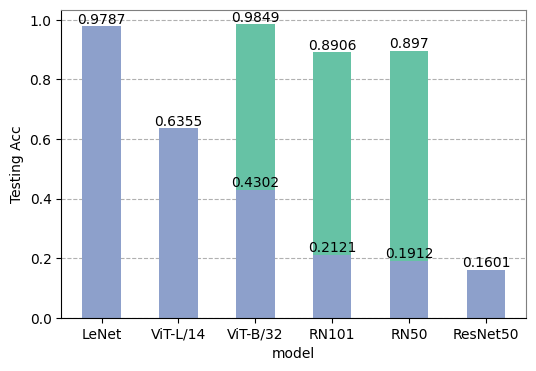

In [62]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_subplot(111)

ax.bar(x, y, width=0.5, color='#8da0cb')

bar_plot2 = ax.bar(x, y2,width=0.5, bottom=y, color='#66c2a5')

ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)
ax.spines[['right', 'top']].set_color('C7')

ax.set_ylabel('Testing Acc')
ax.set_xlabel('model')

for i, j in zip(x, y):
    ax.text(i, j, str(j), ha='center', va='bottom')
for i in range(2,5):
    ax.text(x[i],y1[i],str(y1[i]),ha='center',va='bottom')

    
plt.savefig('clip and lenet.png')
plt.show()